<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/testes_bigrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import pprint as pp
from joblib import dump
from keras.preprocessing import text

In [162]:
data = {'rating':[5.0, 5.0, 2.0, 5.0, 4.0, 4.0, 5.0, 5.0, 1.0, 2.0, 1.0, 2.0, 1.0], 'review_text':['This all-Spanish handbook for parents with new texts for the dumb students learn well', 
                                                                     'not Excellent but ok',
                                                                     'Do you giggle uncontrollably when poking corpses on the river margin',
                                                                     'I think great',
                                                                     'I cannot speak to the literary points in the',
                                                                     'I liked it',
                                                                     'I have read sevral of McCarthys other novels and they are all shit',
                                                                     'bullshit',
                                                                     'If you are considering buying the Peter Smith, think again. This is absolutely garbage',
                                                                     'What I didnt realise when I ordered this is the time',
                                                                     'WTF',
                                                                     'not Excellent', 
                                                                     'bullshit from horse'
                                                                     ]}
df = pd.DataFrame(data)
df.head(5)

,rating,review_text
0,5.0,This all-Spanish handbook for parents with new...
1,5.0,not Excellent but ok
2,2.0,Do you giggle uncontrollably when poking corps...
3,5.0,I think great
4,4.0,I cannot speak to the literary points in the


In [163]:
sample = df[df['rating'] == 2].sample(1)
pp.pprint(sample['review_text'].values[0])
print('-'*100)
print('Number of words: %d' % sample['review_text'].str.split().apply(len))
print('Rating: %d stars' % sample['rating'].values[0])

'not Excellent'
----------------------------------------------------------------------------------------------------
Number of words: 2
Rating: 2 stars


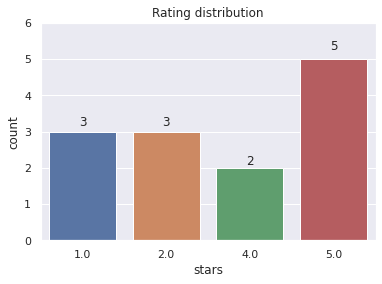

In [164]:

def plot_rating_dist(df, x='rating', title='Rating distribution', xlabel='stars', ylim=6):
    ax = sns.countplot(x=x, data=df)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for rect in ax.containers[0]:
        tw = rect.get_width() / 2.
        tx = rect.get_x() + tw
        height = rect.get_height()
        ty = 1.05 * height
        ax.text(tx, ty, height, ha='center')

    ax.set_ylim(0, ylim)
    
plot_rating_dist(df)

In [165]:

def binary_labels(df, min_set=None):
 
    # Cleanning data set
    count = df['review_text'].str.len()
    df = df[(count > 3) | (count < 4000)].copy()
    
    # Equilize dataset sample size
    if min_set is None:
        min_set = df['rating'].value_counts().min() * 4
    
    # Split rating 1.0, 2.0 as negative reviews
    rating_1 = df[df['rating'] == 1.0].iloc[:min_set // 4]
    rating_2 = df[df['rating'] == 2.0].iloc[:min_set // 4]
    negative_reviews = pd.concat([rating_1, rating_2])
    negative_reviews['label'] = 0
    
    # Split rating 4.0, 5.0 as positive reviews
    rating_4 = df[df['rating'] == 4.0].iloc[:min_set // 4]
    rating_5 = df[df['rating'] == 5.0].iloc[:min_set // 4]
    positive_reviews = pd.concat([rating_4, rating_5])
    positive_reviews['label'] = 1
    
    dataset = pd.concat([negative_reviews, positive_reviews])
    dataset.sort_index(inplace=True)
    
    return dataset

dataset = binary_labels(df,  min_set=10)

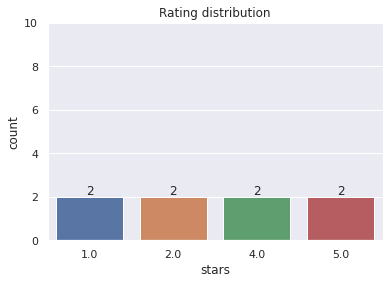

In [166]:
plot_rating_dist(dataset, ylim=10)

texts size:  8
labels size:  8


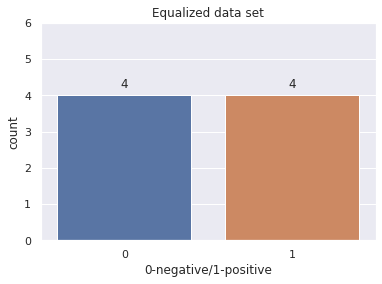

In [167]:
texts = dataset['review_text'].astype(str)
labels = dataset['label'].astype('int32')

print('texts size: ', texts.size)
print('labels size: ', labels.size)

plot_rating_dist(pd.concat([texts, labels], axis=1), x='label', title='Equalized data set', xlabel='0-negative/1-positive', ylim=6)

In [168]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [169]:
MAX_NUM_FEATURES = 20
NGRAN_RANGE = 2
MAX_SEQUENCE_LENGTH = 50
VALIDATION_SPLIT = .1

In [170]:
# from keras.preprocessing import text

tokenizer = text.Tokenizer(num_words=MAX_NUM_FEATURES, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 55 unique tokens.


In [171]:
word_index.get('<OOV>')

1

In [172]:
print(texts[2])
pp.pprint(sequences[2], width=200, compact=True)

Do you giggle uncontrollably when poking corpses on the river margin
[1, 6, 1, 1, 7, 1, 1, 1, 2, 1, 1]


In [173]:
print(sequences)

[[4, 9, 10, 11, 5, 12, 13, 14, 15, 5, 2, 16, 17, 18, 19], [1, 1, 1, 1], [1, 6, 1, 1, 7, 1, 1, 1, 2, 1, 1], [3, 1, 1, 1, 2, 1, 1, 1, 2], [3, 1, 1], [1, 6, 1, 1, 1, 2, 1, 1, 1, 1, 4, 8, 1, 1], [1, 3, 1, 1, 7, 3, 1, 4, 8, 2, 1], [1]]


In [174]:
print(len(sequences), 'sequences')
print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

8 sequences
Average train sequence length: 8


In [175]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [176]:
len(sequences)

8

In [177]:
NGRAN_RANGE

2

In [178]:
sequences[4]

[3, 1, 1]

In [179]:
if NGRAN_RANGE > 1:
    ngram_set = set()
    for input_list in sequences:
        for i in range(2, NGRAN_RANGE + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)
    
    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.        
    token_indice = {v: k + MAX_NUM_FEATURES for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}
    
    # Update MAX_NUM_FEATURES
    MAX_NUM_FEATURES = np.max(list(indice_token.keys())) + 1
    print('Update MAX_NUM_FEATURES %d' % MAX_NUM_FEATURES)
    
    # Augument sequences with the new features
    sequences = add_ngram(sequences, token_indice, NGRAN_RANGE)
    print(len(sequences), 'sequences')
    print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

Update MAX_NUM_FEATURES 48
8 sequences
Average train sequence length: 16


In [180]:
sequences[4]

[3, 1, 1, 43, 47]

In [181]:
indice_token

{20: (2, 16),
 21: (7, 3),
 22: (1, 3),
 23: (10, 11),
 24: (8, 2),
 25: (7, 1),
 26: (4, 8),
 27: (2, 1),
 28: (1, 4),
 29: (9, 10),
 30: (14, 15),
 31: (18, 19),
 32: (1, 6),
 33: (15, 5),
 34: (16, 17),
 35: (17, 18),
 36: (1, 2),
 37: (4, 9),
 38: (11, 5),
 39: (12, 13),
 40: (13, 14),
 41: (5, 12),
 42: (6, 1),
 43: (3, 1),
 44: (8, 1),
 45: (1, 7),
 46: (5, 2),
 47: (1, 1)}

In [182]:
indice_token.get(25)

(7, 1)

In [183]:
new_reviews = ['The most handbook for parents with a', '👍', 'not excellent, but good', 'I cannot speak at the literary points over there', 'this time from horse']
new_sequences = tokenizer.texts_to_sequences(new_reviews)

In [184]:
new_sequences  # 39: (12, 13)

[[2, 1, 11, 5, 12, 13, 1],
 [1],
 [1, 1, 1, 1],
 [3, 1, 1, 1, 2, 1, 1, 1, 1],
 [4, 1, 1, 1]]

In [209]:
temp_list_final = []
for item in new_sequences:
  # print(item)
  temp_list, temp_list2 = [], []
  for each in item:
    # print('--', each)
    if len(temp_list)==0:
      primeiro_item = each  # Primeira vez que passa
      temp_list.append(each)
    else:
      tupla = (primeiro_item, each)
      if token_indice.get(tupla) is not None:
        temp_list2.append(token_indice.get(tupla))
      temp_list.append(each)
      primeiro_item = each
  temp_list = temp_list + temp_list2
  temp_list_final.append(temp_list)
  # print(temp_list)
print(temp_list_final)

[[2, 1, 11, 5, 12, 13, 1, 27, 38, 41, 39], [1], [1, 1, 1, 1, 47, 47, 47], [3, 1, 1, 1, 2, 1, 1, 1, 1, 43, 47, 47, 36, 27, 47, 47, 47], [4, 1, 1, 1, 47, 47]]


In [203]:
listao = [1]
if len(listao)==0:
  print('oidod')

In [188]:
type(lista)

tuple

In [ ]:
indice_token.get

In [50]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [51]:
pp.pprint(data[4].tolist(), width=200, compact=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 37, 38, 101, 77]


In [52]:
# Split the date into train and validation sets
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [53]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape, 'type', y_train.dtype)
print('y_val shape:', y_val.shape, 'type', y_val.dtype)

X_train shape: (0, 40)
X_val shape: (8, 40)
y_train shape: (0,) type int32
y_val shape: (8,) type int32


 Fasttext Model

In [54]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint

In [55]:
def fasttext_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_FEATURES,
                        output_dim=100,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [56]:
model = fasttext_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           10500     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,601
Trainable params: 10,601
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3


UnboundLocalError: ignored